# Імпорт необхідних бібліотек

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder


import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import PIL
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


import re
import string
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU


# Завантаження датасету

In [18]:
data_path = "Automobile.csv"
data = pd.read_csv(data_path)
df_original = data.copy()
missing_data = data.isnull().sum()

if missing_data.sum() > 0:
    print("\nПропущені значення виявлено. Видаляємо їх...")
    data = data.dropna()
def detect_outliers(df):
    outliers = pd.DataFrame()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound))
    
    return outliers

deleted_indices = df_original.index.difference(data.index)

df_deleted_rows = df_original.loc[deleted_indices]

print("\n--- Видалені рядки")
print(f"Загальна кількість видалених рядків: {len(df_deleted_rows)}")
print(df_deleted_rows)
print("\nПеревірка наявності викидів:")
outliers = detect_outliers(data)


Пропущені значення виявлено. Видаляємо їх...

--- Видалені рядки
Загальна кількість видалених рядків: 6
                     name   mpg  cylinders  displacement  horsepower  weight  \
32             ford pinto  25.0          4          98.0         NaN    2046   
126         ford maverick  21.0          6         200.0         NaN    2875   
330  renault lecar deluxe  40.9          4          85.0         NaN    1835   
336    ford mustang cobra  23.6          4         140.0         NaN    2905   
354           renault 18i  34.5          4         100.0         NaN    2320   
374        amc concord dl  23.0          4         151.0         NaN    3035   

     acceleration  model_year  origin  
32           19.0          71     usa  
126          17.0          74     usa  
330          17.3          80  europe  
336          14.3          80     usa  
354          15.8          81  europe  
374          20.5          82     usa  

Перевірка наявності викидів:


# Поділ на набори

In [19]:
data = data.drop(data.columns[[8, 0]], axis=1)
data = data[(data['cylinders'] != 3) & (data['cylinders'] != 5)]
label_encoder = LabelEncoder()
data['cylinders'] = label_encoder.fit_transform(data['cylinders'])
print(data['cylinders'].value_counts())
X = data.drop(columns=['cylinders'])
y = data['cylinders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Підготовка даних завершена. Розміри наборів:")
print(f"Тренувальні ознаки (X_train): {X_train.shape}")
print(f"Тестові ознаки (X_test): {X_test.shape}")

cylinders
0    199
2    103
1     83
Name: count, dtype: int64
Підготовка даних завершена. Розміри наборів:
Тренувальні ознаки (X_train): (269, 6)
Тестові ознаки (X_test): (116, 6)


# 1. Повнозв'язані нейронні мережі

In [20]:
num_classes = len(np.unique(y))
input_shape = X.shape[1]

# Перетворення міток у формат one-hot encoding для багатокласової класифікації
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

model_fcnn = Sequential([
    # Перший прихований шар з активацією ReLU
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3), # Регуляризація
    # Другий прихований шар
    Dense(32, activation='relu'),
    Dropout(0.3),
    # Вихідний шар: активація 'softmax' для багатокласової, 'sigmoid' для бінарної класифікації
    Dense(num_classes, activation='softmax') 
])

# Компіляція моделі
model_fcnn.compile(optimizer='adam',
                   loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
                   metrics=['accuracy'])

model_fcnn.summary()

## 1.2. Навчання та тестування

print("Навчання FCNN...")
# Змініть epochs та batch_size за потреби
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_fcnn = model_fcnn.fit(
    X_train, y_train_cat,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop]
)

"""history_fcnn = model_fcnn.fit(X_train, y_train_cat, 
                              epochs=200, 
                              batch_size=32, 
                              validation_split=0.1, # Використання частини тренувальних даних для валідації
                              verbose=0) # Встановіть 1 для детального виводу"""

# Оцінка на тестовій вибірці
loss_fcnn, acc_fcnn = model_fcnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nТочність FCNN на тестовій вибірці: {acc_fcnn*100:.2f}%")

# Прогнозування та звіт класифікації
y_pred_fcnn_prob = model_fcnn.predict(X_test)
y_pred_fcnn = np.argmax(y_pred_fcnn_prob, axis=1) # Перетворення one-hot на мітки
print("\nЗвіт класифікації FCNN:")
print(classification_report(y_test, y_pred_fcnn))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                448       
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 3)                 99        
                                                                 
Total params: 2,627
Trainable params: 2,627
Non-trainable params: 0
_________________________________________________________________
Навчання FCNN...
Epoch 1/300
8/8 [==================

# Порівняння з результатами із першої лабораторної роботи

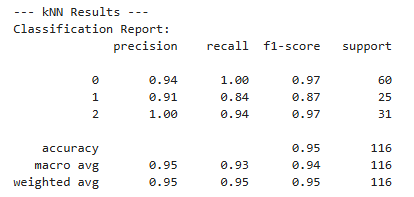]

# 2. Згорткові нейронні мережі

## а) Побудуйте просту згорткову нейронну мережу

11.3.0


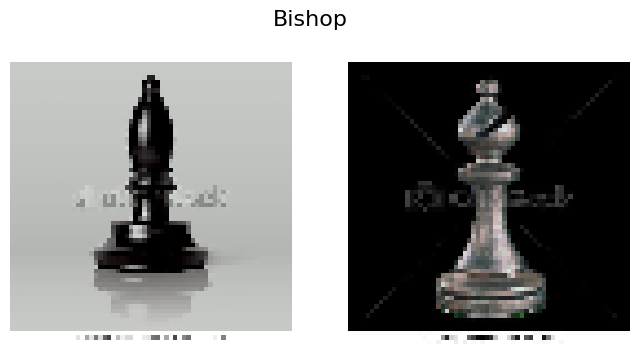

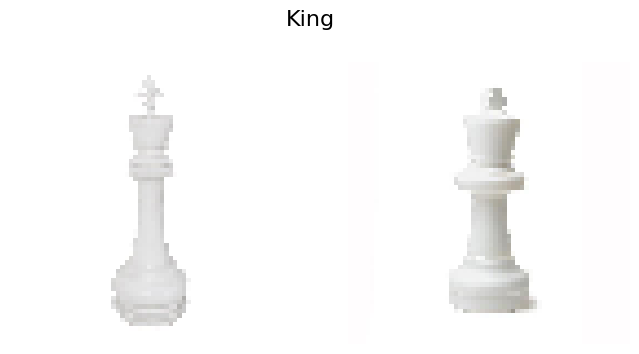

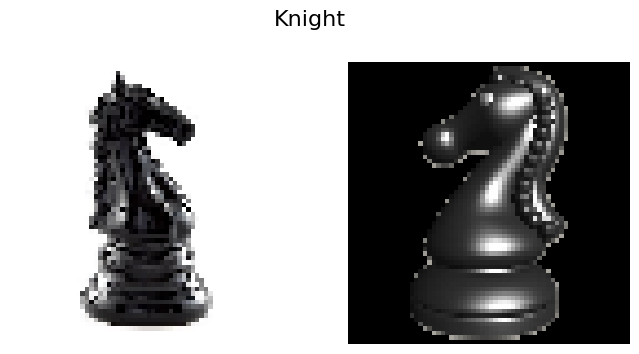

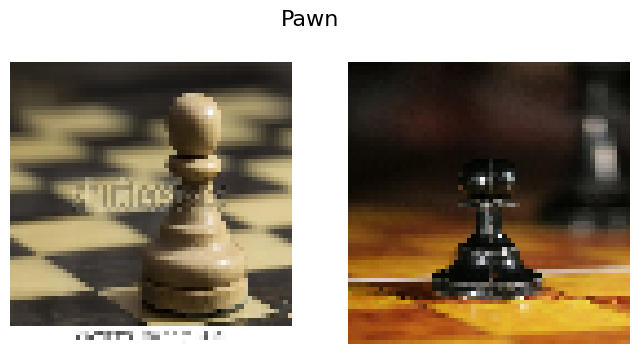

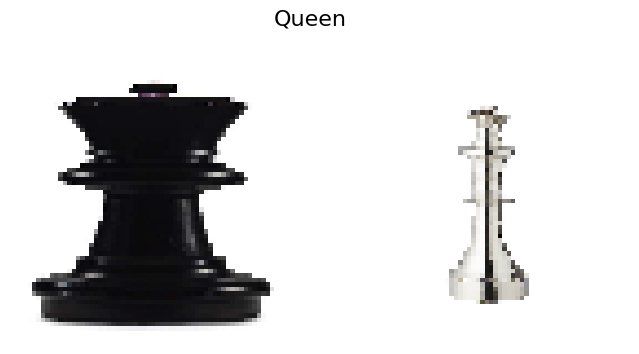

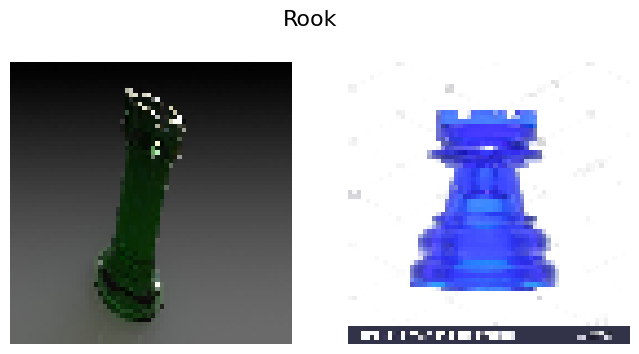

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 128)       

In [21]:
print(PIL.__version__)

path = "Chessman-image-dataset/Chess/"  
img_size = (64, 64)

# Візуалізація категорій 
categories = sorted(os.listdir(path))
for category in categories:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(category, fontsize=16)
    
    files = os.listdir(os.path.join(path, category))
    random.shuffle(files)
    
    for i, filename in enumerate(files[:2]):
        img = load_img(os.path.join(path, category, filename), target_size=img_size)
        axs[i].imshow(img)
        axs[i].axis('off')
    
    plt.show()


X = []
y = []

for idx, category in enumerate(categories):
    folder = os.path.join(path, category)
    files = os.listdir(folder)
    for filename in files:
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        X.append(img_array)
        y.append(idx)

X = np.array(X, dtype='float32')
y = np.array(y)

# One-hot encoding
num_classes = len(categories)
y_cat = to_categorical(y, num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

input_shape = X_train.shape[1:]

# Побудова простої CNN
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,             
    restore_best_weights=True
)

# Навчання
history = model_cnn.fit(
    X_train, y_train,
    epochs=100,              
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model_cnn.evaluate(X_test, y_test, verbose=0)
print(f"\nТочність на тестовій вибірці: {acc*100:.2f}%")

## б) Донавчання

In [10]:
# Базова модель
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape  # (64, 64, 3)
)

# Заморозити всі шари базової VGG16
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(num_classes, activation='softmax')(x)

model_transfer = Model(inputs=base_model.input, outputs=output)

model_transfer.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

# EarlyStopping 
early_stop_tl = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

print("\nНавчання моделі Transfer Learning...")
history_tl = model_transfer.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop_tl],
    verbose=1
)

loss_tl, acc_tl = model_transfer.evaluate(X_test, y_test, verbose=0)
print(f"\nТочність Transfer Learning (VGG16): {acc_tl*100:.2f}%")



=== Transfer Learning з VGG16 ===
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling

# 3.  Вирішіть задачу класифікації текстів

## а) Побудуйте модель з вбудованим Embedding шаром (ініціалізованим випадковими вагами). Використайте RNN / LSTM / GRU для класифікації. Навчіть модель на вашому датасеті.

In [22]:
file_path = "Phishing_Email.csv"
df = pd.read_csv(file_path)

# Видалення першого стовпця
df = df.drop(df.columns[0], axis=1)

# Видалення рядків без тексту
df.dropna(subset=["Email Text"], inplace=True)

print("Перші 5 рядків після завантаження:")
print(df.head())

# Передобробка тексту

stop_words = set(stopwords.words("english"))

def preprocess_text(t):
    t = t.lower()
    t = re.sub(r"http\S+", "", t)  # Видалення URL
    t = t.translate(str.maketrans("", "", string.punctuation))  # Пунктуація
    tokens = [w for w in t.split() if w not in stop_words]  # Стоп-слова
    return " ".join(tokens)

df["Email Text"] = df["Email Text"].apply(preprocess_text)

print("\nПерші 5 рядків після очищення:")
print(df.head())

# Підготовка даних

texts = df["Email Text"].tolist()
labels = df["Email Type"].astype("category").cat.codes  # Конвертація текстових класів у числа
num_classes = len(df["Email Type"].unique())

# Параметри
vocab_size = 10000
embedding_dim = 100
maxlen = 200
oov_tok = "<unk>"

# Токенізація
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(texts)

# Перетворення текстів у послідовності
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Розбиття на train/test
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    labels, 
    test_size=0.2, 
    random_state=42,
    stratify=labels
)

# One-hot
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Модель з RANDOM Embedding + GRU

def create_model_random_emb():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=maxlen),
        Dropout(0.3),
        GRU(128),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model_random_emb()
model.summary()


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train_cat,
    epochs=50,                 
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop],
    verbose=1
)




loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nТочність GRU + Random Embedding: {acc*100:.2f}%")


Перші 5 рядків після завантаження:
                                          Email Text      Email Type
0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email
1  the other side of * galicismos * * galicismo *...      Safe Email
2  re : equistar deal tickets are you still avail...      Safe Email
3  \nHello I am your hot lil horny toy.\n    I am...  Phishing Email
4  software at incredibly low prices ( 86 % lower...  Phishing Email

Перші 5 рядків після очищення:
                                          Email Text      Email Type
0  6 1100 disc uniformitarianism 1086 sex lang di...      Safe Email
1  side galicismos galicismo spanish term names i...      Safe Email
2  equistar deal tickets still available assist r...      Safe Email
3  hello hot lil horny toy one dream open minded ...  Phishing Email
4  software incredibly low prices 86 lower draper...  Phishing Email
Model: "sequential_9"
_________________________________________________________________
 Layer (type)    

## б) Завантажте готові embeddings (наприклад, GloVe). Ініціалізуйте Embedding шар цими вагами. Проведіть навчання.

In [23]:
glove_file_path = "wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt"  

embedding_dim = 50
embeddings_index = {}
with open(glove_file_path, encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) != embedding_dim + 1:  # 1 слово + 50 чисел = 51
            continue  # пропускаємо некоректні рядки
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Завантажено {len(embeddings_index)} словникових векторів GloVe.")

# Створення матриці ваг

embedding_dim = 50  
vocab_size = min(10000, len(tokenizer.word_index) + 1)

# Ініціалізація матриці нулями
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # якщо слово є у GloVe

# Модель з GloVe Embedding

from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

model_glove = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,  # тепер 50
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False),
    Dropout(0.3),
    GRU(128),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
])

model_glove.compile(
    optimizer='adam',
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

model_glove.summary()

# EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping

early_stop_glove = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)


history_glove = model_glove.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop_glove],
    verbose=1
)


loss_glove, acc_glove = model_glove.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nТочність GRU + GloVe Embedding: {acc_glove*100:.2f}%")


Завантажено 1287614 словникових векторів GloVe.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 50)           500000    
                                                                 
 dropout_19 (Dropout)        (None, 200, 50)           0         
                                                                 
 gru_4 (GRU)                 (None, 128)               69120     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                                 
Total